In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread
import tensorflow as tf
import tensorflow.contrib.slim as slim
from utils import unpool_with_argmax
%matplotlib inline

In [2]:
train_file = 'CamVid/train.txt'
val_file = 'CamVid/val.txt'
test_file = 'CamVid/test.txt'

In [3]:
IMAGE_HEIGHT = 72
IMAGE_WIDTH = 96
IMAGE_DEPTH = 3
NUM_CLASSES = 12
TRAIN_BATCH_SIZE=32
VAL_BATCH_SIZE=TRAIN_BATCH_SIZE
TEST_BATCH_SIZE = 1
NUM_ITERS = 2000
NUM_TRAIN = 367

In [4]:
def get_label_colors():
    Sky = [128,128,128]
    Building = [128,0,0]
    Pole = [192,192,128]
    Road_marking = [255,69,0]
    Road = [128,64,128]
    Pavement = [60,40,222]
    Tree = [128,128,0]
    SignSymbol = [192,128,128]
    Fence = [64,64,128]
    Car = [64,0,128]
    Pedestrian = [64,64,0]
    Bicyclist = [0,128,192]
    Unlabelled = [0,0,0]

    label_colors = np.array([Sky, Building, Pole, Road, Pavement, Tree, SignSymbol, 
                             Fence, Car, Pedestrian, Bicyclist, Unlabelled])
    return label_colors

def img_annot_to_rgb(img_annot):
    r = img_annot.copy()
    g = img_annot.copy()
    b = img_annot.copy()
    label_colors = get_label_colors()
    for i in range(len(label_colors)):
        r[img_annot==i]=label_colors[i,0]
        g[img_annot==i]=label_colors[i,1]
        b[img_annot==i]=label_colors[i,2]
    return np.stack([r,g,b],axis=2)/255.0

def visualize_image_annot(img_data, annot_data, predicted_annot=None):
    if predicted_annot is None:
        fig, ax = plt.subplots(1,2,figsize=(10,12))
        ax[0].imshow(img_data)
        ax[0].set_title('Original Image')
        ax[1].imshow(img_annot_to_rgb(annot_data))
        ax[1].set_title('True Segmentation')
        plt.show()
    else:
        fig, ax = plt.subplots(1,3,figsize=(10,12))
        ax[0].imshow(img_data)
        ax[0].set_title('Original Image')
        ax[1].imshow(img_annot_to_rgb(predicted_annot))
        ax[1].set_title('Predicted Segmentation')
        ax[2].imshow(img_annot_to_rgb(annot_data))
        ax[2].set_title('True Segmentation')
        plt.show()

In [5]:
def load_data(file, train=True, batch_size=10, labels=True):
    def _load_image(filename):
        image_string = tf.read_file(filenames[0])
        image_decoded = tf.image.decode_png(image_string, channels=3)
        image_decoded = tf.image.convert_image_dtype(image_decoded,tf.float32)
        return image_decoded

    def _load_image_with_labels(filenames):
        image_string = tf.read_file(filenames[0])
        image_decoded = tf.image.decode_png(image_string, channels=3)
        image_decoded = tf.image.convert_image_dtype(image_decoded,tf.float32)
        image_decoded = tf.image.resize_images(image_decoded, [IMAGE_HEIGHT, IMAGE_WIDTH])
        annot_string = tf.read_file(filenames[1])
        annot_decoded = tf.image.decode_png(annot_string, channels=1)
        annot_decoded = tf.image.resize_images(annot_decoded, [IMAGE_HEIGHT,IMAGE_WIDTH])
        annot_decoded = tf.squeeze(annot_decoded,axis=2)
        annot_decoded = tf.cast(annot_decoded, tf.int64)
        return image_decoded, annot_decoded

    dataset = tf.contrib.data.Dataset.from_tensor_slices(tf.constant([file]))
    dataset =  dataset.flat_map(lambda filename: tf.contrib.data.TextLineDataset(filename))
    dataset = dataset.map(lambda line: tf.string_split([line], delimiter=' ').values)
    if labels:
        dataset = dataset.map(_load_image_with_labels)
    else:
        dataset = dataset.map(_load_image)
    if train is True:
        dataset = dataset.shuffle(buffer_size=batch_size*3)
    dataset = dataset.batch(batch_size=batch_size)
    iterator = dataset.make_initializable_iterator()
    return iterator

In [6]:
train_iterator = load_data(train_file,batch_size=367)

In [7]:
sess = tf.InteractiveSession()

In [8]:
sess.run(train_iterator.initializer)

In [9]:
images, labels = sess.run(train_iterator.get_next())

In [10]:
labels.shape

(367, 72, 96)

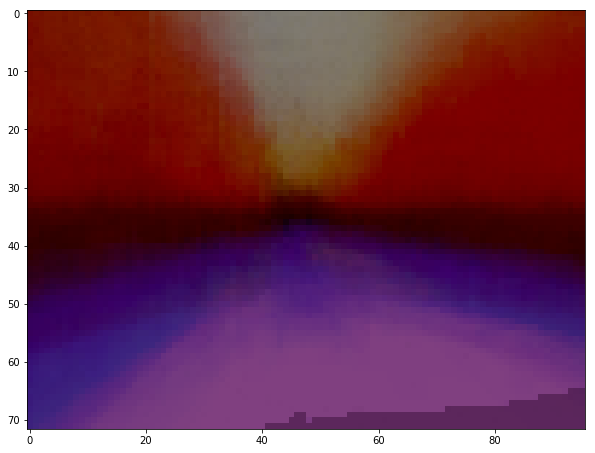

In [17]:
fig, ax = plt.subplots(1,1,figsize=(10,12))
for i in range(367):
    ax.imshow(img_annot_to_rgb(labels[i,:,:]), alpha=0.004)

In [23]:
pixel_hist = np.zeros(12)
for i in range(367):
    pixel_hist += np.bincount(labels[i].reshape(-1),minlength=12)

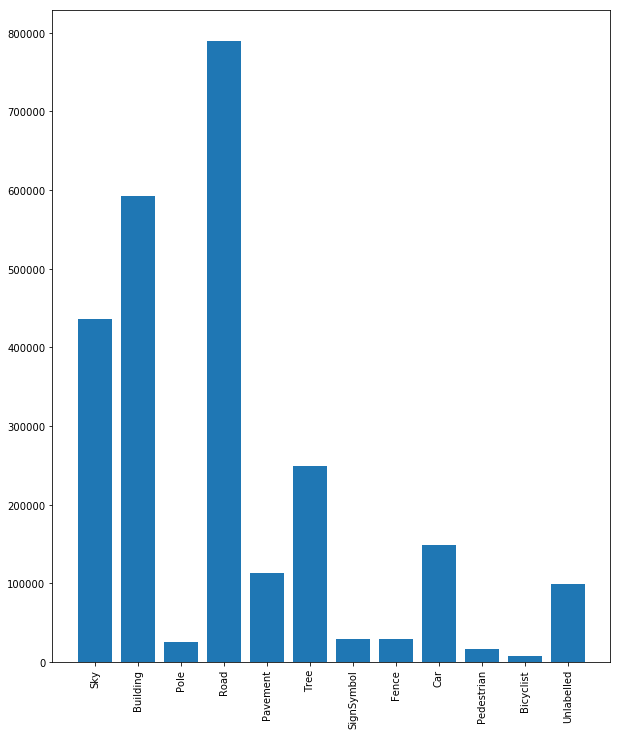

In [41]:
fig, ax = plt.subplots(1,1,figsize=(10,12))
ax_x = np.arange(12)
ax.bar(ax_x,pixel_hist)
ax.set_xticks(ax_x)
ax.set_xticklabels(ax_labels, rotation='vertical')


In [32]:
ax_labels=['Sky', 'Building', 'Pole', 'Road', 'Pavement', 'Tree', 'SignSymbol', 
                             'Fence', 'Car', 'Pedestrian', 'Bicyclist', 'Unlabelled']

In [39]:
pixel_hist

array([ 436608.,  592632.,   25184.,  789860.,  113824.,  248679.,
         29776.,   28674.,  149205.,   16189.,    7442.,   98631.])

In [44]:
pixel_probs=pixel_hist/pixel_hist.sum()

In [46]:
1/pixel_probs

array([   5.81002639,    4.28040335,  100.72681067,    3.21158686,
         22.28619623,   10.20071659,   85.19290704,   88.46704331,
         17.00146778,  156.69306319,  340.86320881,   25.71913496])

In [50]:
np.random.randn(12,2,3)*(1/pixel_probs)

ValueError: operands could not be broadcast together with shapes (12,2,3) (12,) 

In [76]:
pixel_weights=(1/pixel_probs)

In [77]:
final = np.zeros((12,72,96))
for i in range(12):
    final[i,:,:] = pixel_weights[i]

In [81]:
final[1]

array([[ 4.28040335,  4.28040335,  4.28040335, ...,  4.28040335,
         4.28040335,  4.28040335],
       [ 4.28040335,  4.28040335,  4.28040335, ...,  4.28040335,
         4.28040335,  4.28040335],
       [ 4.28040335,  4.28040335,  4.28040335, ...,  4.28040335,
         4.28040335,  4.28040335],
       ..., 
       [ 4.28040335,  4.28040335,  4.28040335, ...,  4.28040335,
         4.28040335,  4.28040335],
       [ 4.28040335,  4.28040335,  4.28040335, ...,  4.28040335,
         4.28040335,  4.28040335],
       [ 4.28040335,  4.28040335,  4.28040335, ...,  4.28040335,
         4.28040335,  4.28040335]])

In [53]:
np.zeros((12,72,96))

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       ..., 
       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0., 

In [71]:
x = np.array([[[[1,1],[1,1]],[[2,2],[2,2]]],[[[3,3],[3,3]],[[4,4],[4,4]]]])

In [56]:
x*np.array([2,3])

array([[ 2,  6],
       [ 6, 12]])

In [60]:
x*np.array([2,3])

array([[[ 2.,  3.],
        [ 2.,  3.],
        [ 2.,  3.]],

       [[ 2.,  3.],
        [ 2.,  3.],
        [ 2.,  3.]]])

In [64]:
x.shape

(2, 2, 2)

In [67]:
x*np.array([[1],[2]])

array([[[1, 1],
        [2, 2]],

       [[2, 2],
        [4, 4]]])

In [69]:
y = np.array([[[2,2],[2,2]],[[3,3],[3,3]]])

In [73]:
x*y

array([[[[ 2,  2],
         [ 2,  2]],

        [[ 6,  6],
         [ 6,  6]]],


       [[[ 6,  6],
         [ 6,  6]],

        [[12, 12],
         [12, 12]]]])

In [72]:
x

array([[[[1, 1],
         [1, 1]],

        [[2, 2],
         [2, 2]]],


       [[[3, 3],
         [3, 3]],

        [[4, 4],
         [4, 4]]]])

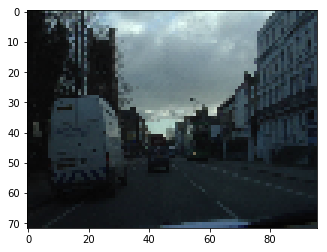

In [15]:
plt.imshow(images[0])
plt.grid(False)

In [12]:
images[0]

array([[[ 0.0627451 ,  0.06666667,  0.06666667],
        [ 0.04705883,  0.0509804 ,  0.0509804 ],
        [ 0.05882353,  0.0627451 ,  0.0627451 ],
        ..., 
        [ 0.14117648,  0.18039216,  0.20392159],
        [ 0.22352943,  0.30588236,  0.32549021],
        [ 0.12941177,  0.18823531,  0.2392157 ]],

       [[ 0.05882353,  0.0627451 ,  0.0627451 ],
        [ 0.04705883,  0.0509804 ,  0.0509804 ],
        [ 0.07058824,  0.07450981,  0.07450981],
        ..., 
        [ 0.16078432,  0.25490198,  0.26666668],
        [ 0.10588236,  0.12156864,  0.19215688],
        [ 0.15294118,  0.21960786,  0.2392157 ]],

       [[ 0.07450981,  0.07450981,  0.06666667],
        [ 0.03921569,  0.03921569,  0.03921569],
        [ 0.05490196,  0.05490196,  0.05490196],
        ..., 
        [ 0.1254902 ,  0.14901961,  0.20000002],
        [ 0.11764707,  0.15294118,  0.20392159],
        [ 0.19607845,  0.28235295,  0.34117648]],

       ..., 
       [[ 0.05490196,  0.07058824,  0.07450981],
        